# General Rotations and Translations


In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import kaolin as kal
from kaolin.datasets import ModelNet, ModelNetVoxels

# from models import *
from dataset.trans_model_net_voxels import TransformedModelNetVoxels


%reload_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda:0'

## Visualize more general rotations on modelnet

In [2]:
modelnet_path = './data/ModelNet10'
categories = ['chair']

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
valset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='test', device=device)
train_loader = DataLoader(trainset, batch_size=1)
val_loader = DataLoader(valset, batch_size=256)

converting to voxels to resolution 32: 100%|██████████| 100/100 [00:00<00:00, 28424.40it/s]


In [2]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6
    if  not singular:
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.round(np.array([x, y, z]), 4)

def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                   ])
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                   ])
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]])
    R = np.dot(R_z, np.dot( R_y, R_x ))
    affine_mat = torch.zeros(1, 3, 4)
    affine_mat[:, :, :3] = torch.FloatTensor(R)
    return affine_mat

def affine_transform(x, affine_params, padding_mode='zeros'):
    grid = F.affine_grid(affine_params, x.size(), align_corners=False).cuda()
    x = F.grid_sample(x, grid, padding_mode=padding_mode, align_corners=False)
    return x

def show_rotations(x, rot_mat_list):
    nrows, ncols = int(len(rot_mat_list)/2), 2
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows*ncols, 1):
        rotated_x = affine_transform(x, rot_mat_list[idx].to(device))    
        rotated_x = rotated_x > .5
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.voxels(rotated_x.squeeze(), facecolors='blue', edgecolor='k')

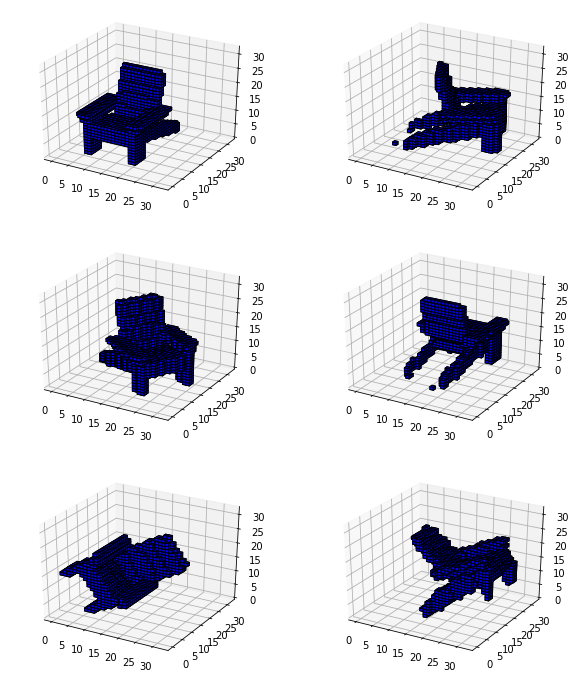

In [11]:
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

rot_mat_list = [
    [0, 0, 0],
    [90, 0, 0],
    [45, 0, 0],
    [135, 0, 0],
    [0, 45, 0],
    [8, 88, 188]
]
rot_mat_list = [eulerAnglesToRotationMatrix(x) for x in rot_mat_list]
show_rotations(x, rot_mat_list)

#### Sanity check - rotations should occupy the same volume
Small changes due to resampling and thresholding, but all <5%, so can probably ignore it

***Note: Using a threshold other than .5 will change the volume a lot***

In [51]:
rot_mat_list = [
    [0, 0, 0],
    [90, 0, 0],
    [45, 0, 0],
    [45, 45, 0],
    [45, 45, 45],
    [135, 135, 135]
]
rot_mat_list = [eulerAnglesToRotationMatrix(x) for x in rot_mat_list]

volumes = []
volumes_after_threshold = []

for rot_mat in rot_mat_list:
    rotated_x = affine_transform(x, rot_mat.to(device))  
    volumes.append(rotated_x.sum().item())
    rotated_x = rotated_x > .5
    volumes_after_threshold.append(rotated_x.sum().item())

for vol, vol_threshold in zip(volumes, volumes_after_threshold):
    print(f'Volume change: {100*vol/volumes[0]:.0f}%, after threshold: {100*vol_threshold/volumes[0]:.0f}%')

Volume change: 100%, after threshold: 100%
Volume change: 99%, after threshold: 99%
Volume change: 99%, after threshold: 98%
Volume change: 97%, after threshold: 95%
Volume change: 99%, after threshold: 97%
Volume change: 100%, after threshold: 98%


## Translations
* When optimizing, we need to be careful not to end up with edge cases where the object is being destroyed
* Loss should encourage this not to happen:
    * Overscaling will distort, after scaling down will be distorted, still can't reconstruct.
    * Translating too much will remove the object, after inverse (moving back), portion of object will still be missing  
* Still, we want to make these kinds of terrible transformations unlikely, and not possible in the data augmentation:


#### Restrictions on transformations
* All rotations, so maximum size is at $45^\circ$, can be increased by $2^.5$, in the unlikely case the full diagonal is occupied
* Scaling - can scale up to the maximum axis of the object in the 32x32 block.
* Translation - Can translate the distance of nearest edge to object
Overall, worst case scenario object must be $2^.5 \times scaling_factor * translation_factor$

Practically, most objects are significantly smaller than the full 32x32, but may not be exactly centered. As an approximation, we will upscale the objects by 
$1.1 \times scaling\_factor * translation\_factor$ instead, since objects so rarely occupy the full diagonal.

Take this as $1.1 \times 1.2 \times 1.2 = 1.584$, and round down to $1.5$.

 .25 padding on each side 
 


#### Consider affine transforms both in terms of a dict including rotation angles, scale, and translation, and the rotation matrix

In [14]:
def get_affine_transform(rot, trans, scale):
    rot = np.array(rot).astype(float)*math.pi/180.
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(rot[0]), -math.sin(rot[0]) ],
                    [0,         math.sin(rot[0]), math.cos(rot[0])  ]
                   ])
    R_y = np.array([[math.cos(rot[1]),    0,      math.sin(rot[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(rot[1]),   0,      math.cos(rot[1])  ]
                   ])
    R_z = np.array([[math.cos(rot[2]),    -math.sin(rot[2]),    0],
                    [math.sin(rot[2]),    math.cos(rot[2]),     0],
                    [0,                     0,                      1]])
    S = np.array([[scale,      0,                  0],
                  [0,             scale,           0],
                  [0,             0,             scale]])
    R = np.dot(R_z, np.dot( R_y, R_x ))
    RS = np.dot(R, S)
    affine_mat = torch.zeros(1, 3, 4)
    affine_mat[:, :, :3] = torch.FloatTensor(RS)
    affine_mat[:, :, 3] = torch.FloatTensor([trans[0],
                                             trans[1],
                                             trans[2]])
    return affine_mat

def pad_3d(x, pad_factor=1.5):
    pad_amt = ((pad_factor-1)*torch.tensor(x.size()[-3:]))/2
    pad_amt = [[int(x.item()), int(x.item())] for x in pad_amt]
    pad_amt = [item for sublist in pad_amt for item in sublist]
    img = F.pad(x, pad_amt, 'constant', 0)
    return img

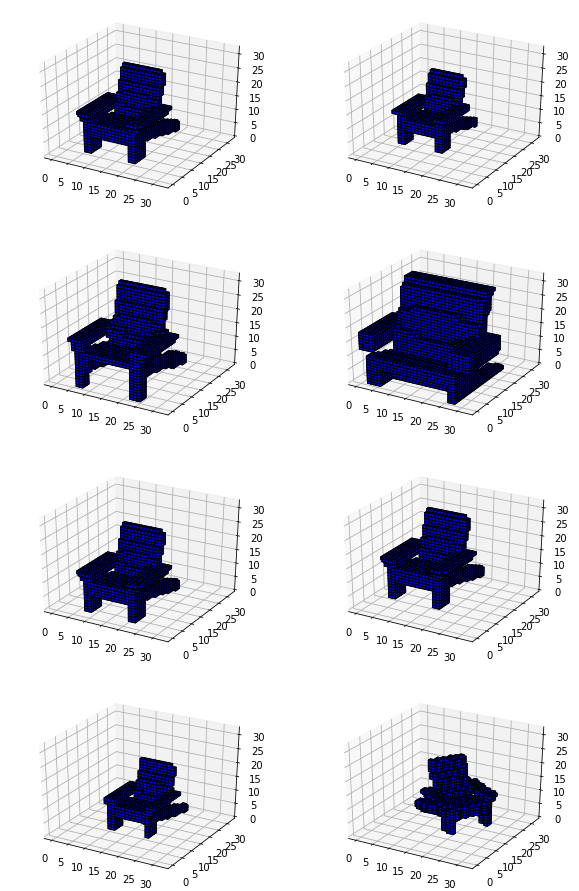

In [108]:
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

affine_args = [
    {'rot': [0, 0, 0],
      'scale':1,
      'trans': [0, 0, 0]}, 
    {'rot': [0, 0, 0],
      'scale':1.2,
      'trans': [0, 0, 0]}, 
    {'rot': [0, 0, 0],
      'scale':0.8,
      'trans': [0, 0, 0]}, 
    {'rot': [0, 0, 0],
      'scale':.5,
      'trans': [0, 0, 0]},
    {'rot': [0, 0, 0],
      'scale':1,
      'trans': [.1, 0, 0]},
    {'rot': [0, 0, 0],
      'scale':1,
      'trans': [-.2, 0, 0]},
    {'rot': [0, 0, 0],
      'scale':1.2,
      'trans': [.2, -.2, -.2]},
    {'rot': [45, 0, 0],
      'scale':1.2,
      'trans': [.2, -.2, -.2]}]
rot_mat_list = [get_affine_transfrom(**args) for args in affine_args]
show_rotations(x, rot_mat_list)

In [109]:
volumes = []
volumes_after_threshold = []

for rot_mat in rot_mat_list:
    rotated_x = affine_transform(x, rot_mat.to(device))  
    volumes.append(rotated_x.sum().item())
    rotated_x = rotated_x > .5
    volumes_after_threshold.append(rotated_x.sum().item())

for vol, vol_threshold in zip(volumes, volumes_after_threshold):
    print(f'Volume change: {100*vol/volumes[0]:.0f}%, after threshold: {100*vol_threshold/volumes[0]:.0f}%')

Volume change: 100%, after threshold: 100%
Volume change: 60%, after threshold: 59%
Volume change: 161%, after threshold: 142%
Volume change: 349%, after threshold: 350%
Volume change: 100%, after threshold: 100%
Volume change: 100%, after threshold: 100%
Volume change: 58%, after threshold: 54%
Volume change: 58%, after threshold: 54%


#### Including padding
.25 padding on each side when transalations = scaling = 1.2

padded x size: torch.Size([1, 1, 48, 48, 48])
Volume change: 100%, after threshold: 100%
Volume change: 434%, after threshold: 436%
Volume change: 173%, after threshold: 173%
Volume change: 174%, after threshold: 174%
Volume change: 172%, after threshold: 171%
Volume change: 169%, after threshold: 169%
Volume change: 172%, after threshold: 172%
Volume change: 174%, after threshold: 173%
Volume change: 177%, after threshold: 177%
Volume change: 113%, after threshold: 113%
Volume change: 116%, after threshold: 116%
Volume change: 118%, after threshold: 117%


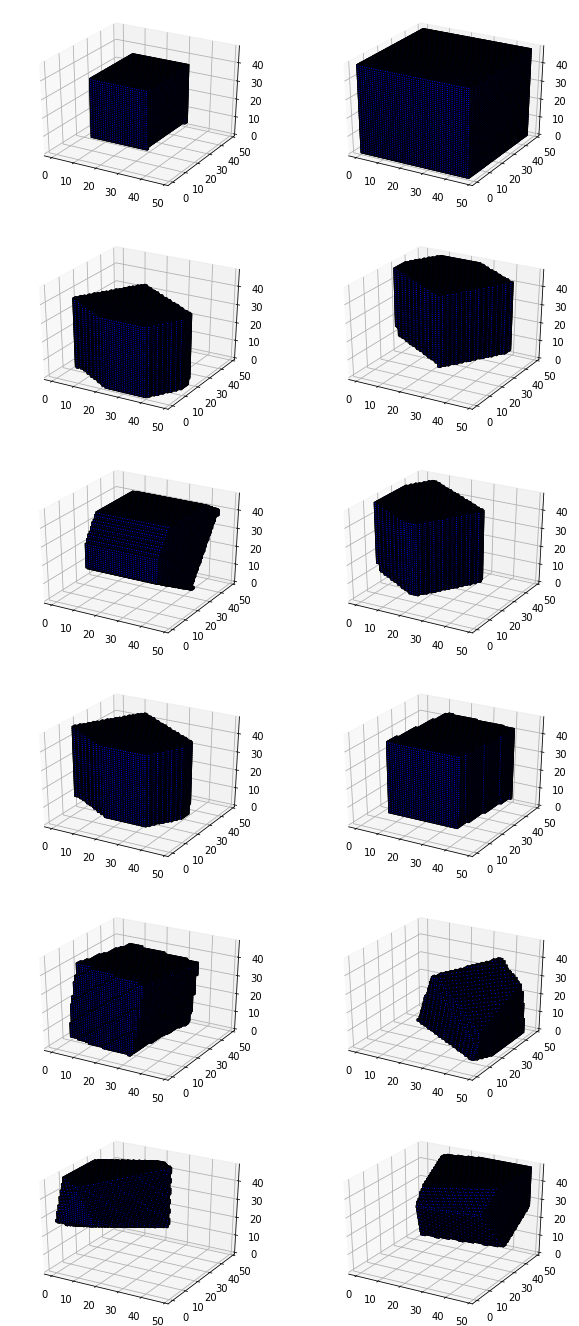

In [37]:
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
x = pad_3d(x, pad_factor=1.5)
print('padded x size:', x.size())

affine_args = [
    {'rot': [0, 0, 0],
      'scale':1,
      'trans': [0, 0, 0]}, 
    {'rot': [0, 0, 0],
      'scale':0.5,
      'trans': [0, 0, 0]}, 
    {'rot': [45, 0, 0],
      'scale':0.8,
      'trans': [.2, .2, .2]}, 
    {'rot': [45, 0, 0],
      'scale':0.8,
      'trans': [-.2, -.2, -.2]}, 
    {'rot': [0, 0, 45],
      'scale':0.8,
      'trans': [-.2, -.2, -.2]}, 
    {'rot': [45, 0, 0],
      'scale':0.8,
      'trans': [-.2, -.2, .2]}, 
    {'rot': [45, 0, 0],
      'scale':0.8,
      'trans': [-.2, .2, .2]}, 
    {'rot': [135, 0, 0],
      'scale':0.8,
      'trans': [-.2, -.2, .2]}, 
    {'rot': [135, 135, 135],
      'scale':0.8,
      'trans': [.2, -.2, .2]},
    {'rot': [45, 135, 188],
      'scale':0.8,
      'trans': [-.4, .4, .4]},
    {'rot': [90, 90, 45],
      'scale':0.8,
      'trans': [.4, -.4, .4]},
    {'rot': [90, 180, 270],
      'scale':0.8,
      'trans': [.4, .4, -.4]}]
rot_mat_list = [get_affine_transfrom(**args) for args in affine_args]
show_rotations(x, rot_mat_list)

volumes = []
volumes_after_threshold = []
for rot_mat in rot_mat_list:
    rotated_x = affine_transform(x, rot_mat.to(device))
    rotated_x_pad = padded_affine_transform(x, affine_trans_dict, device=device, max_scale=max_scale, max_trans=max_trans, rot_factor=rot_factor)
    
    volumes.append(rotated_x.sum().item())
    rotated_x = rotated_x > .5
    volumes_after_threshold.append(rotated_x.sum().item())

for vol, vol_threshold in zip(volumes, volumes_after_threshold):
    print(f'Volume change: {100*vol/volumes[0]:.0f}%, after threshold: {100*vol_threshold/volumes[0]:.0f}%')

## Confirm affine transforms don't push object outside cube - Rotations and Translations
* Grab acceptable transforms that are likely to be bad (45 rotation, max translation)
* Compare the change in volume of objects with and without padding after affine transform

In [8]:
modelnet_path = './data/ModelNet10'
categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 
                   'sofa', 'monitor', 'table', 'toilet', 'bed']

trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=1)
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

converting to voxels to resolution 32: 100%|██████████| 3991/3991 [00:00<00:00, 30340.07it/s]


1.5
1.5 torch.Size([1, 1, 32, 32, 32]) torch.Size([1, 1, 48, 48, 48])
{'rot': [0, 0, 0], 'scale': 1.0, 'trans': [0.4, 0.4, 0.4]}
{'rot': [0, 0, 0], 'scale': 1.0, 'trans': array([0.26666667, 0.26666667, 0.26666667])}
2092.0 2092.0 2092.0009765625 1.0000004668080784


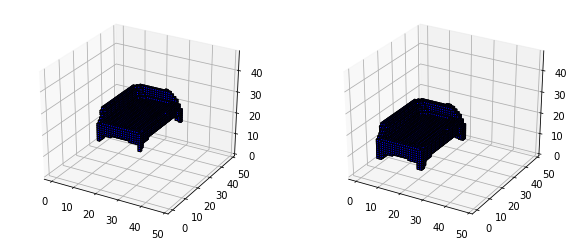

In [90]:
transform = {'rot': [0, 0, 0],
      'scale':1.0,
      'trans': [.4, .4, .4]}

max_trans=.5
rot_factor=1.0

assert transform['scale'] == 1.0
print(rot_factor * (1.0+max_trans))
pad_factor = np.round(rot_factor * (1.0+max_trans), decimals=1)

x_pad = pad_3d(x, pad_factor=pad_factor)
print(pad_factor, x.size(), x_pad.size())

print(transform)
transform['trans'] =  np.array(transform['trans']) / pad_factor
print(transform)
x_pad_t = affine_transform(x_pad, get_affine_transform(**transform).to(device))  
print(x.sum().item(), x_pad.sum().item(), x_pad_t.sum().item(), x_pad_t.sum().item()/x_pad.sum().item())

nrows, ncols = 1, 2
fig = plt.figure(figsize=(10, nrows*4))
ax = fig.add_subplot(nrows, ncols, 1, projection='3d')
ax.voxels(x_pad.squeeze(), facecolors='blue', edgecolor='k')
ax = fig.add_subplot(nrows, ncols, 2, projection='3d')
ax.voxels(x_pad_t.squeeze(), facecolors='blue', edgecolor='k')
plt.show()

In [15]:
def padded_affine_transform(x, transform, device, max_trans=.4, rot_factor=1.1):
    """pad the input and adjust the scaling and translation so the object stays withing the boundary
    Default is 40% translation, and scale object by this. 
    Factor of 1.1 added because of rotations (worst case would need 1.4)
    Assume scaling==1
    
    weirdly in pytorch you use scale as 1/scale, and translation as relative amount of translation
    """    
    assert transform['scale'] == 1.0
    pad_factor = np.round(rot_factor * (1.0+max_trans), decimals=1)
    x_pad = pad_3d(x, pad_factor=pad_factor)
        
    # Final translation is adjusted to be in terms of final object which is increased by pad_factor
    transform['trans'] =  np.array(transform['trans']) / pad_factor

    x_pad = affine_transform(x_pad, get_affine_transform(**transform).to(device))  
    return x_pad

#### Test Volume doesn't change

In [16]:
affine_trans_dicts = [
    {'rot': [0, 0, 0],
      'scale':1.0,
      'trans': [0, 0, 0]}, 
    {'rot': [45, 0, 0],
      'scale':1.0,
      'trans': [0, 0, 0]},
    {'rot': [0, 0, 0],
      'scale':1.0,
      'trans': [.4, 0, 0]},
    {'rot': [0, 0, 0],
      'scale':1.0,
      'trans': [.4, .4, .4]}, 
    {'rot': [45, 0, 0],
      'scale':1.0,
      'trans': [.4, 0, 0]}, 
    {'rot': [45, 0, 0],
      'scale':1.0,
      'trans': [.4, .4, .4]}, 
    {'rot': [45, 0, 0],
      'scale':1.0,
      'trans': [-.4, -.4, -.4]}, 
    {'rot': [45, 45, 135],
      'scale':1.0,
      'trans': [-.4, .4, -.4]}]

results = []
results_pad = []

for batch in train_loader:
    x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0).detach()
    
    base_transform = {'rot': [0, 0, 0],
                      'scale':1.0,
                      'trans': [0, 0, 0]}
    base_vol = affine_transform(x, get_affine_transform(**base_transform).to(device)).sum().item()
    x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
    base_vol_pad = padded_affine_transform(x, base_transform, device=device).sum().item()    
    volumes = []
    volumes_pad = []
    for affine_trans_dict in affine_trans_dicts:
        x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0).detach()
        rotated_x = affine_transform(x, get_affine_transform(**affine_trans_dict).to(device))
        x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0).detach()
        rotated_x_pad = padded_affine_transform(x, affine_trans_dict, device=device)

        volumes.append(rotated_x.sum().item())
        volumes_pad.append(rotated_x_pad.sum().item())

    volumes = [v/base_vol for v in volumes]
    results.append(volumes)
    
    volumes_pad = [v/base_vol_pad for v in volumes_pad]       
    results_pad.append(volumes_pad)

results = pd.DataFrame(results, columns=list(range(len(affine_trans_dicts))))
results_pad = pd.DataFrame(results_pad, columns=list(range(len(affine_trans_dicts))))

In [18]:
print('Volume without padding:')
print(results.mean(axis=0))
display(results.head(n=10))

print('Volume with padding:')
print(results_pad.mean(axis=0))
display(results_pad.head(n=5))

Volume without padding:
0    1.000000
1    0.971476
2    0.999916
3    0.999796
4    0.971396
5    0.971328
6    0.971298
7    0.958370
dtype: float64


,0,1,2,3,4,5,6,7
0,1.0,0.915530,0.807316,0.558017,0.737657,0.587533,0.599642,0.635692
1,1.0,0.988457,1.000000,0.866774,0.988457,0.896643,0.896672,0.903598
2,1.0,0.983900,0.964787,0.903483,0.949976,0.903083,0.856883,0.874846
3,1.0,0.998445,0.997716,0.994275,0.996212,0.983203,0.923362,0.938652
4,1.0,1.000727,0.957837,0.957837,0.958467,0.963326,0.953762,0.980352
5,1.0,1.004340,0.973663,0.973663,0.977888,0.963280,0.983931,0.994626
6,1.0,0.974975,0.981875,0.964635,0.957304,0.952048,0.970463,0.920129
7,1.0,0.968703,0.988264,0.976791,0.957335,0.956762,0.962646,0.905854
8,1.0,0.997559,0.998783,0.998783,0.996360,1.009005,0.985174,0.993961
9,1.0,0.989347,0.998585,0.998585,0.987966,1.000741,0.989935,0.978127


Volume with padding:
0    1.000000
1    1.000619
2    1.000000
3    1.000000
4    1.000619
5    1.000619
6    1.000611
7    0.999954
dtype: float64


,0,1,2,3,4,5,6,7
0,1.0,1.001396,1.0,1.0,1.001396,0.963900,0.971200,0.944781
1,1.0,0.995763,1.0,1.0,0.995763,0.996152,0.996181,0.999902
2,1.0,0.997034,1.0,1.0,0.997034,0.997038,0.997030,0.997834
3,1.0,0.998689,1.0,1.0,0.998689,1.002690,0.999194,0.999960
4,1.0,1.000726,1.0,1.0,1.000726,1.006036,0.995521,1.000045


## Result
* Even with some bad transforms, many objects do not change volume
* Might be overkill to limit our transforms this much, seems like there is a lot of volume "wasted"
* This amount of padding seems like overkill

#### Visualize with and without padding

Volume change: 100%
Volume change: 108%
Volume change: 100%
Volume change: 100%
Volume change: 108%
Volume change: 108%
Volume change: 108%
Volume change: 117%


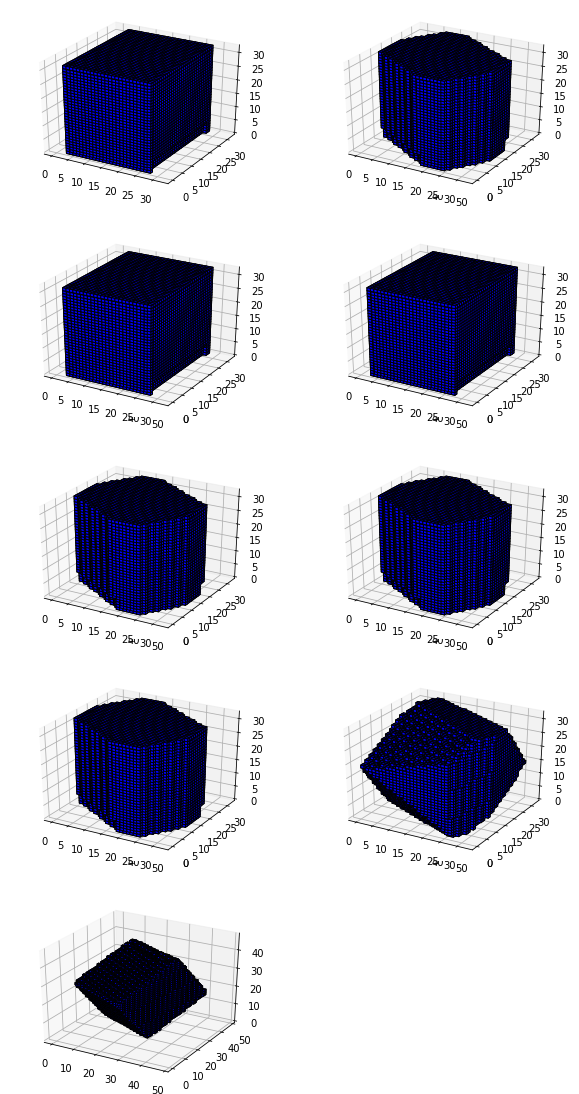

In [22]:
def compare_trans_padded(x, affine_trans_dicts, device):
    nrows, ncols = len(affine_trans_dicts), 2
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows, 1):
        rotated_x = affine_transform(x, get_affine_transform(**affine_trans_dicts[idx]).to(device))
        rotated_x_padded = padded_affine_transform(x, affine_trans_dict, device=device)
        rotated_x = rotated_x > .5
        rotated_x_padded = rotated_x_padded > .5
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.voxels(rotated_x.squeeze(), facecolors='blue', edgecolor='k')
        ax = fig.add_subplot(nrows, ncols, idx + 2, projection='3d')
        ax.voxels(rotated_x_padded.squeeze(), facecolors='blue', edgecolor='k')
        print(f'Volume change: {100*rotated_x_padded.sum().item()/rotated_x.sum().item():.0f}%')
        
compare_trans_padded(x, affine_trans_dicts, device)